In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import random

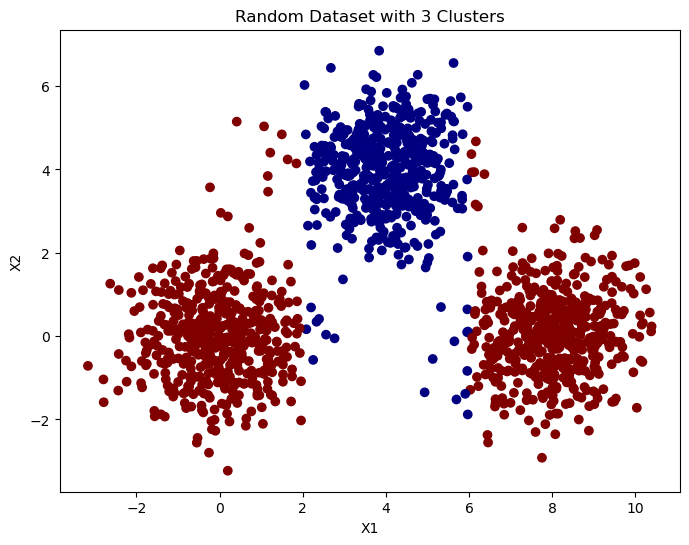

In [67]:
# Generate random data with three clusters
X, y = datasets.make_blobs(n_samples=1500, centers=[[0, 0], [4, 4], [8, 0]], cluster_std=1, random_state=123)

# Assign response values: 0 for the middle cluster, 1 for the other clusters
y[(X[:, 0] > 2) & (X[:, 0] < 6)] = 0
y[(X[:, 0] < 2) | (X[:, 0] > 6)] = 1

# Plot the generated dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.title('Random Dataset with 3 Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Create human experts

## Expert 1

In [63]:
def expert1(inputs):
    return np.where((inputs[:,0] > 2), 1, 0)

In [64]:
y_expert1 = expert1(X)

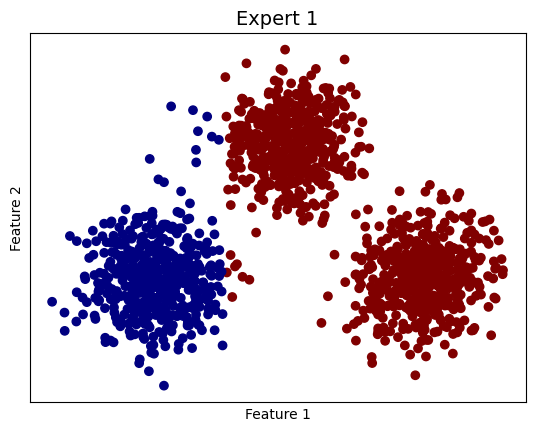

In [65]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert1, cmap='jet')
plt.show()

## Expert 2

In [69]:
def expert2(inputs):
    return np.where((inputs[:,0] < 2), 1, 0)

In [70]:
y_expert2 = expert2(X)

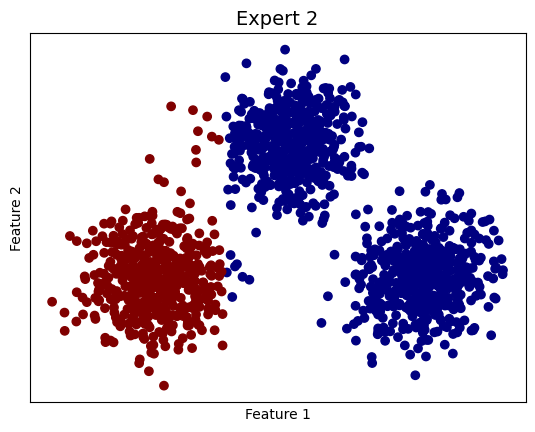

In [71]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert2, cmap='jet')
plt.show()

# Generate training dataset

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=456)

# Train model and rejector

In [73]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [74]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

In [75]:
def run_classifier_rej(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*50)

    for epoch in range(100):  # loop over the dataset multiple times
        #running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        order = np.array(range(len(data_x)))
        np.random.shuffle(order)
        # in-place changing of values
        inputs[np.array(range(len(data_x)))] = inputs[order]
        labels[np.array(range(len(data_x)))] = labels[order]

        x_batches = torch.split(inputs,2)
        y_batches = torch.split(labels,2)  

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2

            if rand_exp == 1:
                predicted = torch.tensor(expert1(inputs))
            elif rand_exp == 2:
                predicted = torch.tensor(expert2(inputs))

            h = (predicted==labels)*1
            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)


            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2) # this is loss for classifier and rejector
            loss.backward()
            optimizer.step()
            scheduler.step()
            #running_loss += loss.item()
            loss_train.append(loss.item())
    
    # Visualize 
    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
            #print("loss " + str(loss.item()))

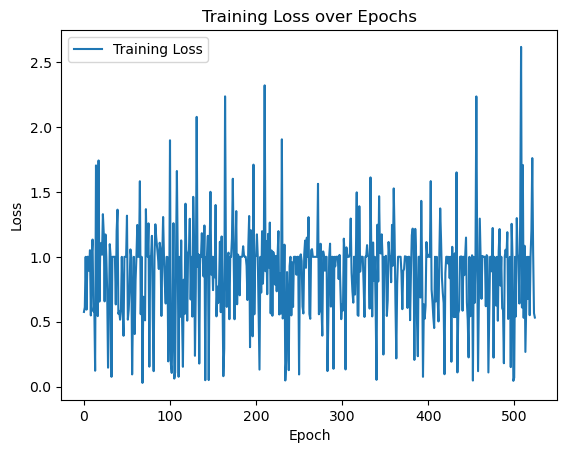

In [76]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, X_train, y_train, alpha, p)

# Test overall system with a sequence of experts

In [77]:
def test_classifier_rej(model, data_x, data_y, p, exp1_instances, exp2_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)
        predicted_exp1 = torch.tensor(expert1(inputs))
        predicted_exp2 = torch.tensor(expert2(inputs))
        
        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2 for each point
                if rand_exp == 1:
                    correct_sys += (predicted_exp1[i] == labels[i]).item()
                    exp1 += (predicted_exp1[i] == labels[i]).item()
                    exp1_total += 1
                    exp1_instances.append(i)
                elif rand_exp == 2:
                    correct_sys += (predicted_exp2[i] == labels[i]).item()
                    exp2 += (predicted_exp2[i] == labels[i]).item()
                    exp2_total += 1
                    exp2_instances.append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100*exp1_total/points) # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:",100* exp1/(exp1_total+0.0002)) # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100*exp2_total/points) # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:",100* exp2/(exp2_total+0.0002)) # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total/exp2_total)
    print()
    print("overall expert count:", exp1_total+exp2_total) # how many times deferred to expert
    print("overall expert defer percent:", 100*(exp1_total+exp2_total)/points) # percentage of times deferred to any expert
    print("overall expert correct predictions:", exp1+exp2) # how many times expert was correct
    print("overall expert accuracy:", 100 * (exp1+exp2) / (exp1_total + exp2_total + 0.0001)) # correct predictions of expert alone
    

    return exp1_instances, exp2_instances

In [78]:
# keep track of what instances are deferred to each expert by index
exp1_instances = []
exp2_instances = []

exp1_instances, exp2_instances = test_classifier_rej(m, X_test, y_test, p, exp1_instances, exp2_instances)

system accuracy 86.66666666666667
total points: 450

expert 1 defer count: 51
expert 1 defer percent: 11.333333333333334
expert 1 correct predictions: 25
expert 1 accuracy: 49.019415610134864

expert 2 defer count: 57
expert 2 defer percent: 12.666666666666666
expert 2 correct predictions: 31
expert 2 accuracy: 54.38577408500321

not deferred to expert count: 342
not deferred percent: 76.0
model correct predictions: 334
model accuracy: 97.6607901576637

expert 1 to expert 2 ratio 0.8947368421052632

overall expert count: 108
overall expert defer percent: 24.0
overall expert correct predictions: 56
overall expert accuracy: 51.851803840922365
